Esse é um notebook com uma análise inicial dos modelos mais usados na competição de NLP, o código e as explicações desse código são retiradas de códigos disponibilizados por competidores humildes. A partir daqui teremos uma noção inicial do que fazer na competição, os modelos que são estado da arte nesse tipo de avaliação, ao fim dele saberemos o que deve ser estudado e aprofundado, além disso poderemos ter noção para onde partir, o que podemos melhorar.

Fontes:

https://www.kaggle.com/code/yongsukprasertsuk/0-812-5-fold-deberta-lgbm?scriptVersionId=172806983#%E2%96%B6%EF%B8%8F-Ensemble-%E2%97%80%EF%B8%8F

https://www.kaggle.com/code/xianhellg/more-feature-engineering-feature-selection-0-817#Data-Loading

https://www.kaggle.com/code/zulqarnainalipk/lgbm-deberta-explained/notebook


https://www.kaggle.com/code/hideyukizushi/aes2-deberta-lgbm-countvectorizer-lb-819 (0.819)

In [ ]:
#Principais coisas a estudar: LGBM, Deberta e ensamble learning

**Lembre de adaptar se for usar fora do colab**

#Visualização inicial dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/CompNLP/test.csv')
test

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
test['predicted_score'] = 0

In [ ]:
test #Só há realmente 3 testes

,essay_id,full_text,predicted_score
0,000d118,Many people have car where they live. The thin...,0
1,000fe60,I am a scientist at NASA that is discussing th...,0
2,001ab80,People always wish they had the same technolog...,0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CompNLP/sample_submission.csv') #Como o nome diz esse é só um exemplo de submissão

In [ ]:
df

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/CompNLP/train.csv')
train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


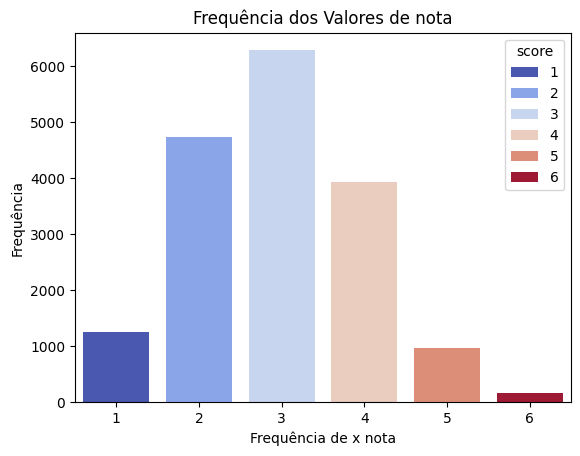

In [ ]:
frequency = train['score'].value_counts().reset_index()
frequency.columns = ['score', 'Frequency']
sns.barplot(data=frequency, x='score', y='Frequency', hue='score', palette='coolwarm')
plt.xlabel('Frequência de x nota')
plt.ylabel('Frequência')
plt.title('Frequência dos Valores de nota')
plt.show()

In [ ]:
train['full_text'][5]

"If I were to choose between keeping the electoral college or abolishing it, I would chose for abolishing it. The electoral college has a system that can be considered confusing to most americans. This system indirectly transfers citizen's votes to congress. This allows for loopholes and sabaotage to be commited during the process of electing a president.\n\nI propose abolishing the electoral college and replacing it with a simpler system that appeals to all united states citizens instead of just certain citizens. Based on phrases in the passage, there is evidence that the electoral college system is corrupt. An example would be:\n\nBack in 1960. segregationalists in the Louisiana legislature nearly succeeded in relpacing the Democratic electors with new electors who would oppose John F. Kennedy. (So that a popular vote for Kennedy would not have actually gone to Kennedy.)\n\n-source 2, second paragraph.\n\nThis is stating that in 1960 people who opposed Kennedy nearly became his elect

In [ ]:
train['full_text'][2]

'People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to get on the bandwagon and come up with the new and improved technology that they hope will appeal to everyone. As of right now, it seems as though the negative characteristics of these cars consume the positive idea that these manufacturers have tried to convey.\n\nCurrently, this new technology in cars has a very long way to go before being completely "driverless". Drivers still need to be on alert when they are driving, as well as control the car near any accidents or complicated traffic situations. This seems to totally defeat the purpose of the "driverless" car. Eventually the technology may improve, but nobody can be certain that the driverless car will eventually become 

Não há muito o que analisar no dataset, só há uma feature além do texto, que é sua nota. Não muito o que retirar da leitura bruta do texto. Logo caberá a nós a partir de informações do texto extrairmos informações importantes e úteis para a avaliação dos textos.

# Bertopic:

In [ ]:
pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 23.3 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [ ]:
from bertopic import BERTopic

In [ ]:
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = set(stopwords.words('english'))
stopwords=list(stopwords)
vectorizer_model  = CountVectorizer(stop_words=stopwords)

In [ ]:
#Vou deixar aqui todas as bibliotecas e funções necessárias a serem importadas para deixar o resumo completo:
from bertopic.representation import MaximalMarginalRelevance
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [ ]:
#Setando os parâmetros do HDBSCAN e do UMAP, além de retirar as stopwords da representação, o mesmo que fiz durante todo o estudo
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True, random_state=50)
vectorizer_model  = CountVectorizer(stop_words=stopwords)

In [ ]:
#Inicialização a representação multípla, algo que vejo como muito útil
prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
generator = pipeline('text2text-generation', model='google/flan-t5-base')
main_representation = KeyBERTInspired()
aspect_model1 = TextGeneration(generator)
aspect_model2 = MaximalMarginalRelevance(diversity=0.8)
representation_model = {
   "Main": main_representation,
   "Aspect1":  aspect_model1,
   "Aspect2":  aspect_model2 }

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
topic_model10 = BERTopic(umap_model=umap_model, embedding_model = 'all-mpnet-base-v2',
                         vectorizer_model = vectorizer_model, calculate_probabilities=True,
                         min_topic_size=20, representation_model=representation_model)

In [ ]:
topicos10, probs10 = topic_model10.fit_transform(df_treino['full_text'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
topic_model10.get_topic_info()

,Topic,Count,Name,Representation,Aspect1,Aspect2,Representative_Docs
0,0,3498,0_driverless_driveless_driver_driving,"[driverless, driveless, driver, driving, drive...","[driverless cars, , , , , , , , , ]","[driverless, driveless, driver, driving, drive...",[Driverless cars are a dangerous thing that th...
1,1,3043,1_emotion_emotions_emotional_faces,"[emotion, emotions, emotional, faces, face, sm...","[facial expressions in a classroom, , , , , , ...","[emotion, emotions, emotional, faces, face, sm...",[A new technology called the Facial Action Cod...
2,2,3018,2_venus_planets_planet_explore,"[venus, planets, planet, explore, exploring, a...","[venus, , , , , , , , , ]","[venus, planets, planet, explore, exploring, a...",[Studying Venus is a worthy pursuit despite th...
3,3,2093,3_face_mars_martian_mesa,"[face, mars, martian, mesa, landform, aliens, ...","[aliens face the mesa of mars, , , , , , , , , ]","[face, mars, martian, mesa, landform, aliens, ...","[Many people believe this very famous ""Face on..."
4,4,2046,4_electors_electoral_elector_elect,"[electors, electoral, elector, elect, voters, ...","[election of electors, , , , , , , , , ]","[electors, electoral, elector, elect, voters, ...","[Dear state senator,\n\nThere should be a chan..."
5,5,1961,5_driving_vehicles_car_cars,"[driving, vehicles, car, cars, pollution, emis...","[diesel emissions, , , , , , , , , ]","[driving, vehicles, car, cars, pollution, emis...",[The effect of cars in our world today has gro...
6,6,1648,6_seagoing_cowboy_adventure_ship,"[seagoing, cowboy, adventure, ship, cowboys, t...","[cowboys on a boat travel the sea, , , , , , ,...","[seagoing, cowboy, adventure, ship, cowboys, t...",[My name is Luke Bomberger and I made nine tri...


In [ ]:
topic_model10.visualize_topics()

In [ ]:
topic_model10.visualize_heatmap()

Olhando um pouco mais para os termos da representação e sua influência nela:

In [ ]:
topic_model10.visualize_barchart(n_words = 10)

In [ ]:
topic_model10.visualize_term_rank()

Mostrando uma das mais importantes funções do HDBSCAN, vou hierarquizar os tópicos para ser possíveis visualizar os estágios mais acima dos clusters

In [ ]:
hierarchical_topics = topic_model10.hierarchical_topics(df_treino['full_text'])

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


In [ ]:
topic_model10.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

Agora uma forma mais detalhada para conseguirmos olhar os documentos mais especificamente em cada tópico

In [ ]:
topic_distr, topic_token_distr = topic_model10.approximate_distribution(df_treino['full_text'], calculate_tokens=True)
topic_model10.visualize_approximate_distribution(df_treino['full_text'][965], topic_token_distr[965])

,Humans,are,slowly,destroying,earth,and,scientists,have,not,found,successful,plan,for,us,to,follow,Further,exploration,into,Venus,could,lead,to,safe,place,for,humans,and,proof,that,there,has,been,other,lifeforms,Venus,could,quite,possibly,be,safe,for,humans,If,humans,use,hovercraft,to,float,above,the,surface,temperatures,would,be,about,170,degrees,Fahrenheit,It,would,be,hot,but,it,would,be,survivable,There,are,also,signs,showing,that,there,was,oncewater,we,could,do,water,restoration,project,to,have,waterthere,again,We,have,been,searching,for,signs,of,lifeforms,for,the,longest,time,Venus,shows,signs,of,what,we,have,been,searching,for,The,planet,has,signs,of,previous,oceans,and,has,analagous,features,to,Earth,It,has,rocky,sediment,and,mountains,This,could,mean,there,was,once,lifeforms,on,Venus,In,conclusiom,further,exploration,of,Venus,could,answer,some,of,our,questions,These,questions,having,to,do,with,the,plan,for,when,Earth,finally,gives,up,and,the,conspiracies,of,if,there,are,other,lifeforms
0_driverless_driveless_driver_driving,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.196,0.196,0.196,0.196,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_emotion_emotions_emotional_faces,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.137,0.137,0.137,0.137,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_venus_planets_planet_explore,0.000,0.000,0.000,0.114,0.312,0.312,0.312,0.198,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.513,0.798,1.084,0.834,0.571,0.286,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.171,0.359,0.516,0.710,0.538,0.350,0.194,0.000,0.000,0.102,0.102,0.102,0.102,0.000,0.000,0.000,0.000,0.107,0.241,0.375,0.375,0.268,0.134,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.155,0.305,0.487,0.671,0.516,0.366,0.184,0.000,0.000,0.000,0.000,0.102,0.374,0.495,0.615,0.513,0.240,0.120,0.000,0.000,0.000,0.000,0.000,0.176,0.423,0.565,0.565,0.389,0.142,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.171,0.342,0.458,0.574,0

In [ ]:
topic_model10.visualize_distribution(topic_distr[965])

Agora essa visualização hierarquizada, podendo subir os níveis hierarquicos e ver como se comparta a distribuição dos documentos nos tópicos

In [ ]:
topic_model10.visualize_hierarchical_documents(df_treino['full_text'], hierarchical_topics, reduced_embeddings=reduced_embeddings)

IndexError: index -1 is out of bounds for axis 0 with size 0

#Feature Extration + análise delas

Pensar e analisar outras features que podemos criar a partir dos textos

##Contador de parágrafos:

In [ ]:
train['paragraph'] = train['full_text'].str.split('\n\n') #Vou fazer uma coluna com a divisão em parágrafos

In [ ]:
train

,essay_id,full_text,score,paragraph
0,000d118,Many people have car where they live. The thin...,3,[Many people have car where they live. The thi...
1,000fe60,I am a scientist at NASA that is discussing th...,3,[I am a scientist at NASA that is discussing t...
2,001ab80,People always wish they had the same technolog...,4,[People always wish they had the same technolo...
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[We all heard about Venus, the planet without ..."
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[Dear, State Senator, This is a letter to argu..."
...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""..."
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...
17304,fff016d,If you don't like sitting around all day than ...,2,[If you don't like sitting around all day than...
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut..."


In [ ]:
train['paragraph'][2]

['People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to get on the bandwagon and come up with the new and improved technology that they hope will appeal to everyone. As of right now, it seems as though the negative characteristics of these cars consume the positive idea that these manufacturers have tried to convey.',
 'Currently, this new technology in cars has a very long way to go before being completely "driverless". Drivers still need to be on alert when they are driving, as well as control the car near any accidents or complicated traffic situations. This seems to totally defeat the purpose of the "driverless" car. Eventually the technology may improve, but nobody can be certain that the driverless car will eventually becom

In [ ]:
train.explode('paragraph') #Essa função fará uma nova linha para cada parágrafo do texto (ver se uso isso ou n)

,essay_id,full_text,score,paragraph
0,000d118,Many people have car where they live. The thin...,3,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...,3,I am a scientist at NASA that is discussing th...
1,000fe60,I am a scientist at NASA that is discussing th...,3,"First off, how could it be a martions drawing...."
1,000fe60,I am a scientist at NASA that is discussing th...,3,"Next, why it is a landform. There are many lan..."
1,000fe60,I am a scientist at NASA that is discussing th...,3,"Finaly, why you should listen to me. You shoul..."
...,...,...,...,...
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,"In ""The Challenge of Exporing Venus,"" the auth..."
17306,fffed3e,Venus is worthy place to study but dangerous. ...,2,Venus is worthy place to study but dangerous. ...
17306,fffed3e,Venus is worthy place to study but dangerous. ...,2,of the Planet.
17306,fffed3e,Venus is worthy place to study but dangerous. ...,2,Just like when they sent a robot to the planet...


In [ ]:
train['n_paragraph'] = 0

In [ ]:
len(train['paragraph'][2])

4

In [ ]:
train['n_paragraph'] = train['paragraph'].str.len()

In [ ]:
train

,essay_id,full_text,score,paragraph,n_paragraph
0,000d118,Many people have car where they live. The thin...,3,[Many people have car where they live. The thi...,1
1,000fe60,I am a scientist at NASA that is discussing th...,3,[I am a scientist at NASA that is discussing t...,5
2,001ab80,People always wish they had the same technolog...,4,[People always wish they had the same technolo...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",5
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[Dear, State Senator, This is a letter to argu...",6
...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",3
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,6
17304,fff016d,If you don't like sitting around all day than ...,2,[If you don't like sitting around all day than...,3
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",1


In [ ]:
train['full_text'][0]

'Many people have car where they live. The thing they don\'t know is that when you use a car alot of thing can happen\xa0like you can get in accidet or\xa0the smoke that the car has is bad to breath\xa0on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban\'s families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden\xa0on the outskirts of freiburd that near the French and Swiss borders. You probaly won\'t see a car in Vauban\'s streets because they are completely "car free" but\xa0If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states an

Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely "car free" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called "smart planning". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that "All of our development since World war 2 has been centered on the cars,and that will have to change" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called "car reduced"communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this.    

In [ ]:
#Realmente há textos com 1 único parágrafo

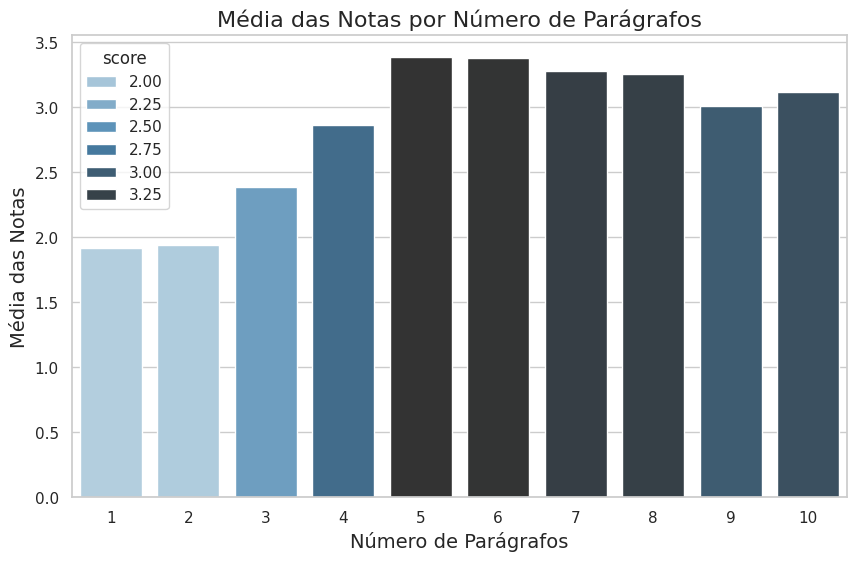

In [ ]:
dataset_filtrado = train[train['n_paragraph'] <= 10]
media_notas_por_paragrafo = dataset_filtrado.groupby('n_paragraph')['score'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x='n_paragraph', y='score', data=media_notas_por_paragrafo, hue = 'score', palette="Blues_d")
plt.xlabel('Número de Parágrafos', fontsize=14)
plt.ylabel('Média das Notas', fontsize=14)
plt.title('Média das Notas por Número de Parágrafos', fontsize=16)
plt.show()

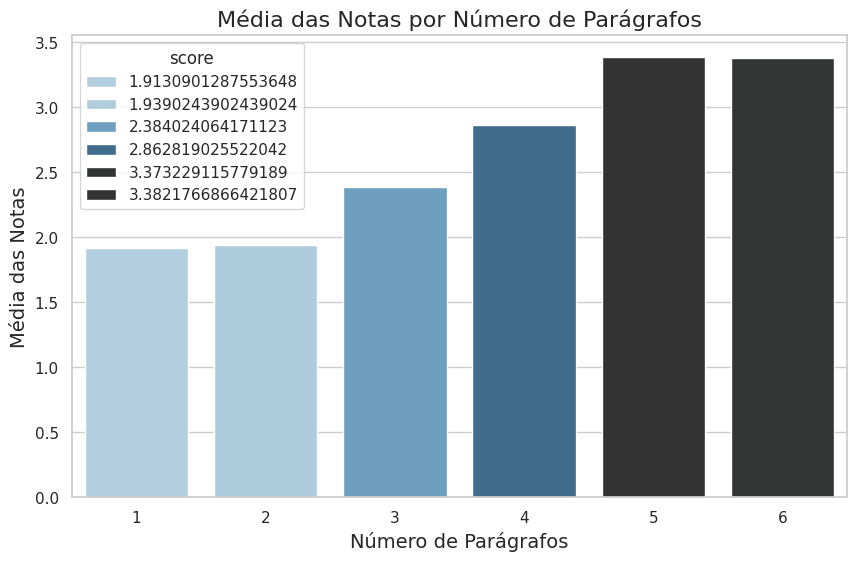

In [ ]:
dataset_filtrado = train[train['n_paragraph'] <=6]
media_notas_por_paragrafo = dataset_filtrado.groupby('n_paragraph')['score'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x='n_paragraph', y='score', data=media_notas_por_paragrafo, hue = 'score', palette="Blues_d")
plt.xlabel('Número de Parágrafos', fontsize=14)
plt.ylabel('Média das Notas', fontsize=14)
plt.title('Média das Notas por Número de Parágrafos', fontsize=16)
plt.show()

In [ ]:
num = train[train['n_paragraph']>6]

In [ ]:
len(num)

2141

In [ ]:
num = train[train['n_paragraph']>10]

In [ ]:
len(num)

587

In [ ]:
num

,essay_id,full_text,score,paragraph,n_paragraph
7,0033bf4,What is the Seagoing Cowboys progam?\n\nIt was...,3,"[What is the Seagoing Cowboys progam?, It was ...",26
21,007db64,This is right because the use of this technolo...,2,[This is right because the use of this technol...,21
23,008341a,A Seagoing Cowboy is someone who helped take a...,3,[A Seagoing Cowboy is someone who helped take ...,22
82,019e8c3,Driverless cars could be the car of the future...,3,[Driverless cars could be the car of the futur...,30
118,0226250,In this article Driverless Cars are coming i a...,4,[In this article Driverless Cars are coming i ...,13
...,...,...,...,...,...
17084,fc76be4,"germany,paris,columbia and now the usa have be...",1,"[germany,paris,columbia and now the usa have b...",29
17086,fc772da,"""The Challenge of Exploring Venus"" is an artic...",3,"[""The Challenge of Exploring Venus"" is an arti...",18
17274,ff5e20b,Have you ever had the oppritunity of a lifetim...,3,[Have you ever had the oppritunity of a lifeti...,20
17283,ff96497,"German Suburb, Life\n\nGoes On Without Cars\n\...",2,"[German Suburb, Life, Goes On Without Cars, No...",21


In [ ]:
train['n_paragraph'].describe()

count    17307.000000
mean         4.965274
std          3.311622
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max         66.000000
Name: n_paragraph, dtype: float64

In [ ]:
texto_66_paragrafos = train[train['n_paragraph'] == 66]['full_text'].iloc[0]
print(texto_66_paragrafos)

A new hom

whould you send someone to explore venus with the technology that we haave

right now? the author of the article

the challege of exploring venus made some

very import points about

why

we sohould explore venus.

the author believes that even. that is worthy exploring venus using old tecnology and new tecnology for example. the mechamical computers, NASA's idea of the ships and the new materials that were being testes

firt of all the author explains the old technology that is used ti be use in

during

the 1940 word war two by making

calculations using

gears and

levers. no electronic were needed for this computer. the only problem would be that the the computers are very delicated when is put to extreme conditions.

secondly the author mentions an idea that NASA

has that he explains could

to very useful for exploring venus.

the author

explains that venus has a very high temperature but the vehicle would hover

30 miles over

from

the surface of venus where is woul

In [ ]:
texto_66_paragrafos = train[train['n_paragraph'] == 66].iloc[0]
texto_66_paragrafos

essay_id                                                 29aa983
full_text      A new hom\n\nwhould you send someone to explor...
score                                                          2
paragraph      [A new hom, whould you send someone to explore...
n_paragraph                                                   66
Name: 2789, dtype: object

In [ ]:
pontos = train[train['n_paragraph'] >10]['score'].mean()
pontos

2.926746166950596

In [ ]:
pontos = train[train['n_paragraph'] >30]['score'].mean()

In [ ]:
pontos

3.048780487804878

In [ ]:
#Analisar esses com muitos

In [ ]:
'''
def Paragraph_Preprocess(tmp):
    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
    tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)

    return tmp
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea
def Paragraph_Eng(train_tmp):
    num_list = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600]
    num_list2 = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700]
    aggs = [
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_>{i}_cnt") for i in [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700] ],
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_<{i}_cnt") for i in [25,49]],

        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],

        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))'''

#Ele usa no código mas não entendi direito para que

##Erro de grafia e processamentos

Primeiro vou tirar dos textos as contrações usadas no idioma inglês, isso pode ser útil para uniformizar os textos, além disso removerei tagas e deixarei tudo em letras minúsculas

In [ ]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

In [ ]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

In [ ]:
with open('/content/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)
def count_spelling_errors(text):


    doc = nlp(text)
    lemmatized_tokens = [token.lemma_.lower() for token in doc]

    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
    return spelling_errors

In [ ]:
train['num_erros_digitação'] = train['full_text'].apply(count_spelling_errors)

In [ ]:
train

,essay_id,full_text,score,paragraph,n_paragraph,num_erros_digitação
0,000d118,Many people have car where they live. The thin...,3,[Many people have car where they live. The thi...,1,65
1,000fe60,I am a scientist at NASA that is discussing th...,3,[I am a scientist at NASA that is discussing t...,5,44
2,001ab80,People always wish they had the same technolog...,4,[People always wish they had the same technolo...,4,62
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",5,70
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[Dear, State Senator, This is a letter to argu...",6,59
...,...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",3,25
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,6,92
17304,fff016d,If you don't like sitting around all day than ...,2,[If you don't like sitting around all day than...,3,19
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",1,41


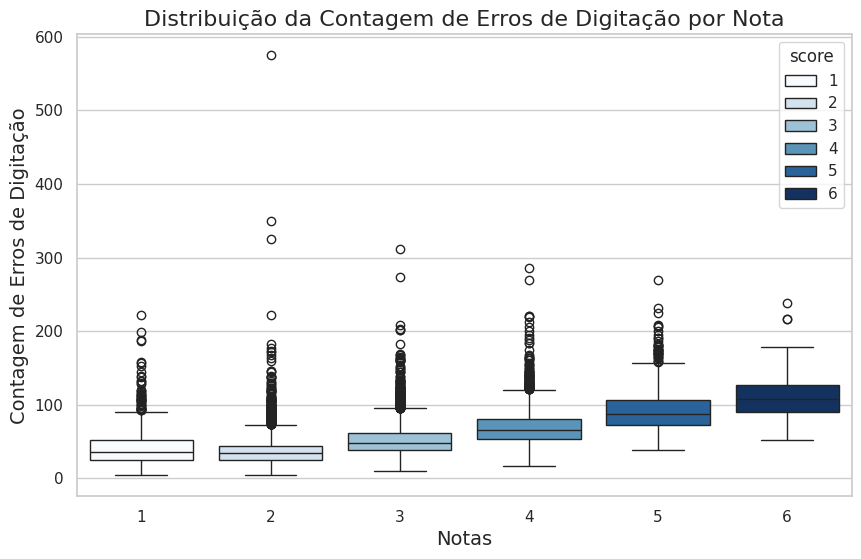

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='score', y='num_erros_digitação', data=train, hue = 'score', palette="Blues")
plt.title('Distribuição da Contagem de Erros de Digitação por Nota', fontsize=16)
plt.xlabel('Notas', fontsize=14)
plt.ylabel('Contagem de Erros de Digitação', fontsize=14)
plt.show()

In [ ]:
media_erros_por_nota = train.groupby('score')['num_erros_digitação'].mean().reset_index()

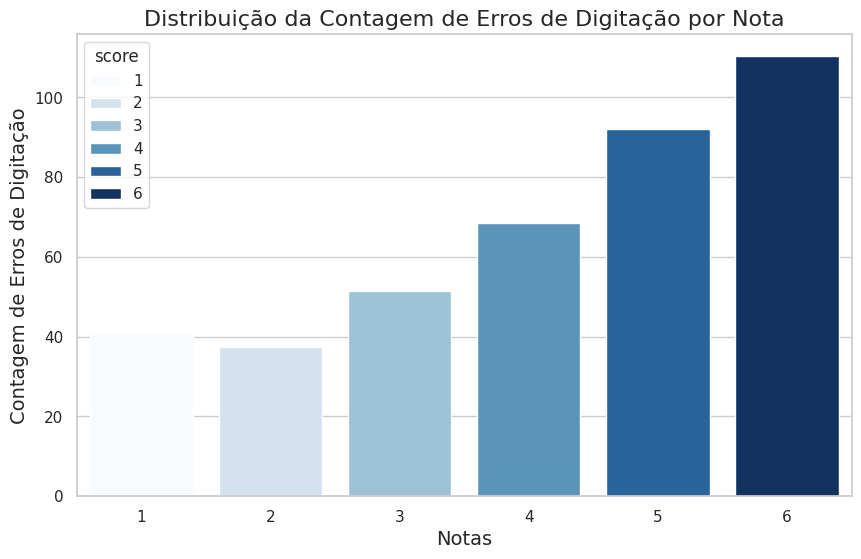

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='num_erros_digitação', data=media_erros_por_nota, hue = 'score', palette="Blues")
plt.title('Distribuição da Contagem de Erros de Digitação por Nota', fontsize=16)
plt.xlabel('Notas', fontsize=14)
plt.ylabel('Contagem de Erros de Digitação', fontsize=14)
plt.show()

In [ ]:
train['full_text'] = train['full_text'].apply(removeHTML)
train['full_text'] = train['full_text'].apply(expandContractions)
train['full_text'] = train['full_text'].apply(dataPreprocessing)

Fazer uma feature relativa que conte o numero de erros pelo numero de palavras e dps ver a relação com a nota.

##Contador de palavras

In [ ]:
def word_count(text):
    return len(text.split())
train['word_count'] = train['full_text'].apply(word_count)

In [ ]:
train['word_count'].describe()

count    17307.000000
mean       368.940891
std        150.776672
min        150.000000
25%        253.000000
50%        345.000000
75%        453.000000
max       1656.000000
Name: word_count, dtype: float64

##Sentenças

In [ ]:
'''
import polars as pl
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))

    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))

    return tmp
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_>{i}_cnt") for i in [0,15,50,100,150,200,250,300] ],
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_<{i}_cnt") for i in [15,50] ],

        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea],

        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))'''


#Entender por que ele faz assim o contador de sentença

In [ ]:
import nltk
nltk.download('punkt')

def sentence_count(text):
    sentences = nltk.sent_tokenize(text)
    return len(sentences)

# Exemplo de uso:
train['sentence_count'] = train['full_text'].apply(sentence_count)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def avg_sentence_length(text):
    sentences = nltk.sent_tokenize(text)
    word_count = sum(len(nltk.word_tokenize(sentence)) for sentence in sentences)
    return word_count / len(sentences) if len(sentences) > 0 else 0

# Exemplo de uso:
train['avg_sentence_length'] = train['full_text'].apply(avg_sentence_length)

In [ ]:
train

,essay_id,full_text,score,paragraph,n_paragraph,num_erros_digitação,word_count,sentence_count,avg_sentence_length
0,000d118,many people have car where they live. the thin...,3,[Many people have car where they live. The thi...,1,65,494,13,41.461538
1,000fe60,i am a scientist at nasa that is discussing th...,3,[I am a scientist at NASA that is discussing t...,5,44,334,21,17.666667
2,001ab80,people always wish they had the same technolog...,4,[People always wish they had the same technolo...,4,62,550,24,25.208333
3,001bdc0,"we all heard about venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",5,70,448,20,25.100000
4,002ba53,"dear, state senator this is a letter to argue ...",3,"[Dear, State Senator, This is a letter to argu...",6,59,373,15,27.800000
...,...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" the challenge of exploing venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",3,25,157,9,18.555556
17303,ffddf1f,technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,6,92,574,26,24.461538
17304,fff016d,if you do not like sitting around all day than...,2,[If you don't like sitting around all day than...,3,19,220,15,15.666667
17305,fffb49b,"in ""the challenge of exporing venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",1,41,227,11,23.636364


In [ ]:
def conjunction_count(text):
    conjunctions = ["and", "but", "or", "nor", "for", "yet", "so", "although", "though", "even though","while", "whereas", "despite", "in spite of", "however", "nevertheless", "nonetheless","regardless", "furthermore", "moreover", "besides", "in addition", "additionally","on the other hand", "otherwise", "instead", "hence", "thus", "consequently", "accordingly", "therefore", "as a result", "because", "since", "due to", "as","inasmuch as", "provided that", "unless", "if", "even if", "whether", "while", "after","before", "when", "whenever", "wherever", "as soon as", "as long as", "in case", "lest","so that", "in order that", "since", "in the event that", "unless", "until", "once","whenever", "than"]
    tokens = nltk.word_tokenize(text.lower())
    return sum(1 for token in tokens if token in conjunctions)

In [ ]:
def adverb_count(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    return sum(1 for word, tag in tags if tag.startswith('RB'))

In [ ]:
train['conjunction_count'] = train['full_text'].apply(conjunction_count)

In [ ]:
nltk.download('averaged_perceptron_tagger')
train['adverb_count'] = train['full_text'].apply(adverb_count)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train

,essay_id,full_text,score,paragraph,n_paragraph,num_erros_digitação,word_count,sentence_count,avg_sentence_length,conjunction_count,adverb_count
0,000d118,many people have car where they live. the thin...,3,[Many people have car where they live. The thi...,1,65,494,13,41.461538,35,21
1,000fe60,i am a scientist at nasa that is discussing th...,3,[I am a scientist at NASA that is discussing t...,5,44,334,21,17.666667,19,21
2,001ab80,people always wish they had the same technolog...,4,[People always wish they had the same technolo...,4,62,550,24,25.208333,44,53
3,001bdc0,"we all heard about venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",5,70,448,20,25.100000,32,23
4,002ba53,"dear, state senator this is a letter to argue ...",3,"[Dear, State Senator, This is a letter to argu...",6,59,373,15,27.800000,21,14
...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" the challenge of exploing venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",3,25,157,9,18.555556,16,9
17303,ffddf1f,technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,6,92,574,26,24.461538,31,20
17304,fff016d,if you do not like sitting around all day than...,2,[If you don't like sitting around all day than...,3,19,220,15,15.666667,18,15
17305,fffb49b,"in ""the challenge of exporing venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",1,41,227,11,23.636364,13,18


## palavras únicas

In [ ]:
def palavras_unicas(text):
    words = nltk.word_tokenize(text.lower())
    unique_words = set(words)
    return len(unique_words) / len(words) if len(words) > 0 else 0

train['palavras_unicas'] = train['full_text'].apply(palavras_unicas) #Porcentualmente

In [ ]:
train

,essay_id,full_text,score,paragraph,n_paragraph,num_erros_digitação,word_count,sentence_count,avg_sentence_length,conjunction_count,adverb_count,palavras_unicas
0,000d118,many people have car where they live. the thin...,3,[Many people have car where they live. The thi...,1,65,494,13,41.461538,35,21,0.417440
1,000fe60,i am a scientist at nasa that is discussing th...,3,[I am a scientist at NASA that is discussing t...,5,44,334,21,17.666667,19,21,0.409704
2,001ab80,people always wish they had the same technolog...,4,[People always wish they had the same technolo...,4,62,550,24,25.208333,44,53,0.381818
3,001bdc0,"we all heard about venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",5,70,448,20,25.100000,32,23,0.440239
4,002ba53,"dear, state senator this is a letter to argue ...",3,"[Dear, State Senator, This is a letter to argu...",6,59,373,15,27.800000,21,14,0.354916
...,...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,"the story "" the challenge of exploing venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",3,25,157,9,18.555556,16,9,0.562874
17303,ffddf1f,technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,6,92,574,26,24.461538,31,20,0.377358
17304,fff016d,if you do not like sitting around all day than...,2,[If you don't like sitting around all day than...,3,19,220,15,15.666667,18,15,0.451064
17305,fffb49b,"in ""the challenge of exporing venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",1,41,227,11,23.636364,13,18,0.515385


In [ ]:
from google.colab import files
train.to_csv('textos_features.csv', index=False)
files.download('textos_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Remoção de pontuação pra processar os modelos

In [ ]:
import string

def remove_punctuation(text):

    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

text = "Hello, world! This is a test."
print(remove_punctuation(text))

#TF-IDF, BoW e modelos

Ver como adpatar o código do cara para o tipo de processamento que fiz ou se uso o código dele e fdc